### Imports

In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import os

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim

from utils.generic_utils import build_mapping_from_raw, build_Xy_from_raw
from utils.visual_utils import show_dataset
from utils.model import EMNISTDataset, SimpleCNN

from torchsummary import summary

<br>
<br>

### References

In [3]:
base_path = r'D:\datasets\text\EMNIST\archive'

train_path = os.path.join(base_path, 'emnist-byclass-train.csv')
test_path = os.path.join(base_path, 'emnist-byclass-test.csv')
ref_path = os.path.join(base_path, 'emnist-byclass-mapping.txt')

assert os.path.exists(train_path)
assert os.path.exists(test_path)
assert os.path.exists(ref_path)

<br>
<br>

In [4]:
# Leitura dos dados e metadados

df_train = pd.read_csv(train_path, header=None)

with open(ref_path, 'r') as f:
    mapping = f.read()

In [5]:
# Transformação dos dados brutos em par (variáveis, gabarito)

X, y = build_Xy_from_raw(df_train)
del df_train

In [6]:
# contruindo mapeamento do target

mapping = build_mapping_from_raw(mapping)

In [7]:
# Divisão treino / teste

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Converter pandas -> numpy arrays
X_train = X_train.values.astype(np.float32)
X_test  = X_test.values.astype(np.float32)
y_train = y_train.values.astype(np.int64)
y_test  = y_test.values.astype(np.int64)

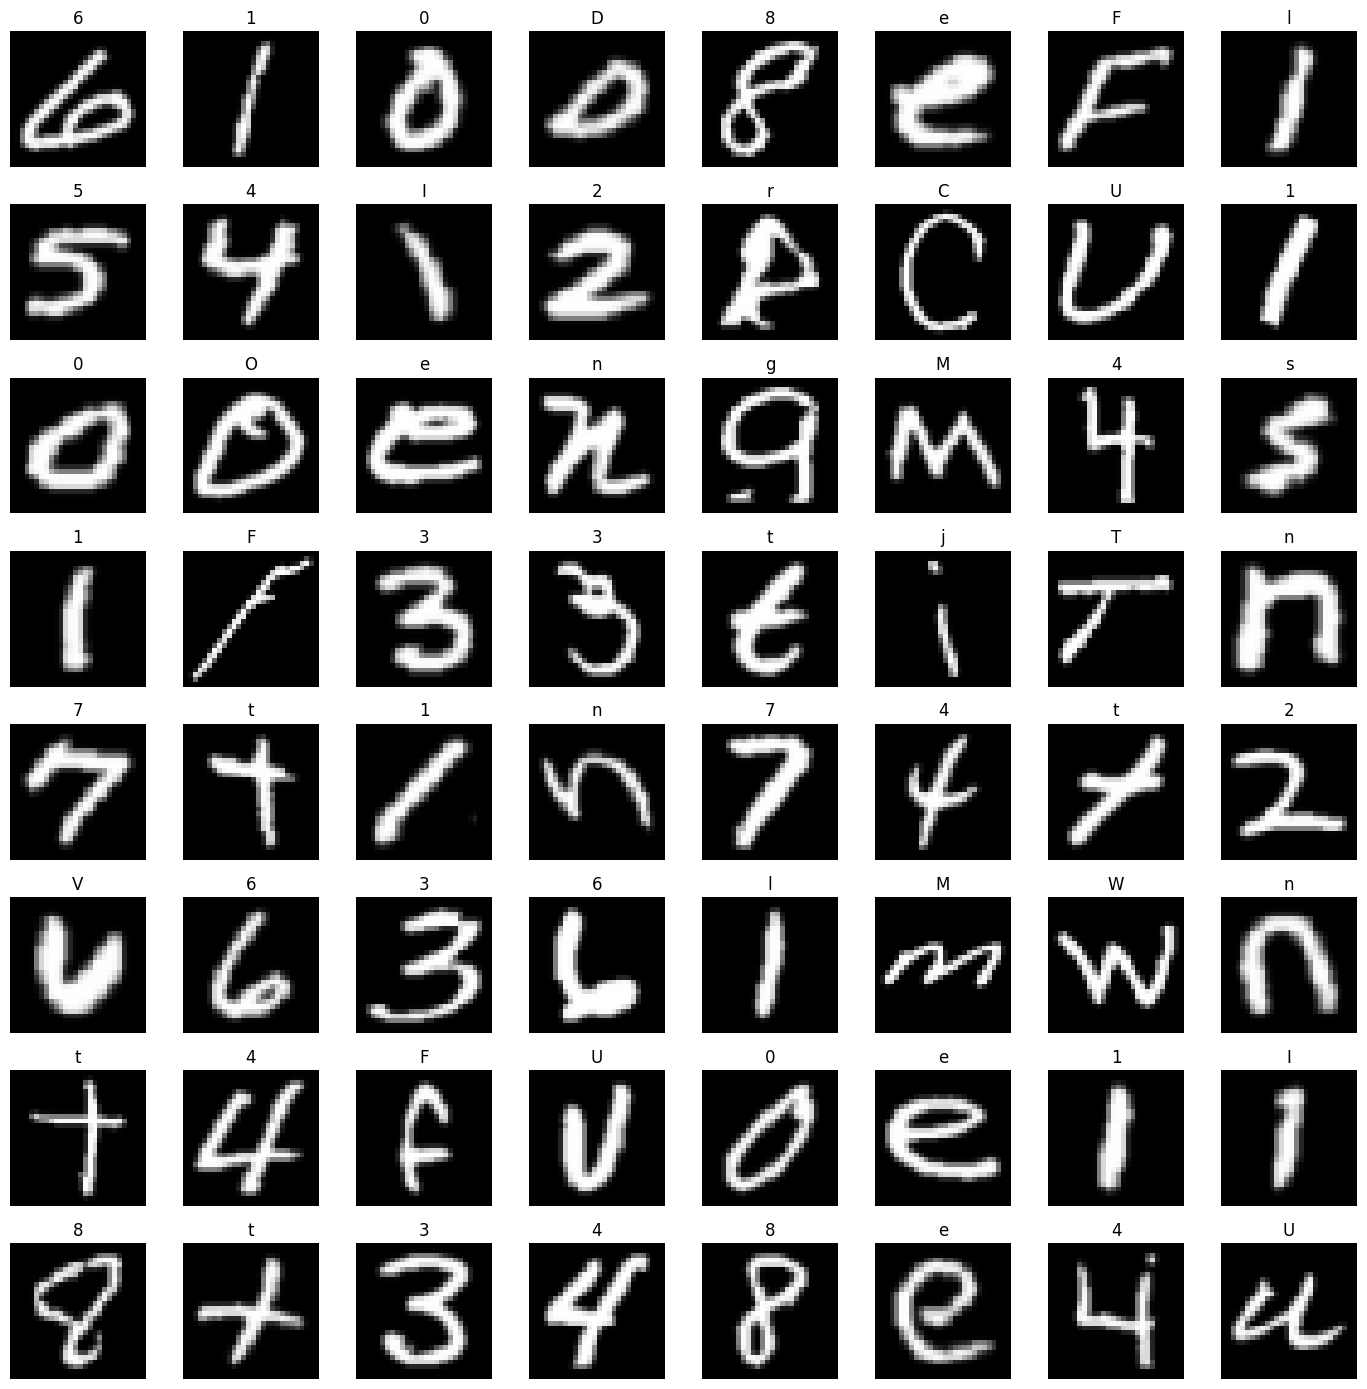

In [8]:
show_dataset(X=X_train, y=y_train, label_map=mapping, start_idx=15)

In [ ]:
batch_size = 64
prefetch_size = 10
num_workers = 0

train_ds = EMNISTDataset(X_train, y_train)
test_ds  = EMNISTDataset(X_test, y_test)

train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True,
    num_workers=num_workers, 
    # prefetch_factor=prefetch_size, 
    # pin_memory=True
)

test_loader  = DataLoader(
    test_ds,  batch_size=batch_size, shuffle=False,
    num_workers=num_workers, 
    # prefetch_factor=prefetch_size, 
    # pin_memory=True
)

In [ ]:
# Definindo o dispositivo de treinamento

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

In [ ]:
# Instanciação do modelo

model = SimpleCNN(num_classes=len(mapping)).to(device)
summary(model, input_size=(1, 28, 28))

<br>
<br>

### Treinamento

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

epochs = 5

for epoch in range(1, epochs + 1):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}/{epochs} - Loss: {epoch_loss:.4f}")